# **Load libraries**

In [2]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')
import sys
lesions = '/content/drive/MyDrive/AI_Lesions_Project/CHUOralLesions.csv'

Mounted at /content/drive


In [3]:
from sklearn.neural_network import MLPClassifier
from pandas import read_csv
import pandas as pd
import numpy as np
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from datetime import datetime
from sklearn.svm import SVC



In [4]:
# Define functions to do PCA,drawCorrelationMap and visualize columns
def plotCorrelationHeatmap(dataframe, columnsToPlot):
    correlation = dataframe[columnsToPlot].corr()
    plt.figure(figsize = (16,5))
    heatmap = sns.heatmap(correlation, xticklabels=correlation.columns,
                          yticklabels=correlation.columns, annot=True,cmap='Blues')


    return heatmap


def visualiseColumn(dataFrame,columnsToVisualize):
    plt.rcParams['font.family'] = 'serif'
    for column in columnsToVisualize:
      unique_values = dataFrame[column].dropna().unique()
      value_counts = dataFrame[column].value_counts()
      n_unique = len(unique_values)

      plt.bar(unique_values, value_counts, color='#1a80bb', edgecolor='black', linewidth=0.5, zorder=2)
      plt.xlabel(column)
      plt.ylabel("Number of occurrences")
      plt.title(f'Occurances by {column}',loc='left')

      # Calculate value counts and put the text at the top of the bar
      value_counts = dataFrame[column].value_counts()
      plt.grid(axis='y', color='gray', alpha=0.3, zorder=-1)

      plt.show()

In [5]:
def plot_precision_recall(clf, X_test, y_test):
    # Predict probabilities on the test set
    y_probs = clf.decision_function(X_test)

    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

    # Compute average precision
    average_precision = average_precision_score(y_test, y_probs)

    # Plot precision-recall curve
    plt.figure()
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

    # Print classification report
    y_pred = clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Show plot
    plt.show()

# **Data Cleaning**

In [6]:
df = read_csv(lesions,sep=";")

In [7]:
#replace empty string with nan
df = df.replace(r'^\s*$', np.nan, regex=True)
#replace unwanted values with nan
df['Stupefies'] = df['Stupefies'].replace('OH', np.nan)
df['Dysplasia'] = df['Dysplasia'].replace('LANGUE',np.nan)




In [8]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)


Missing Values:
Elementary lesion      0
Color                  0
Homogene               0
Well_Delimited         0
Reticulated            0
Bourgeonnant           0
Papillomatous          0
Age                  246
Sex                  213
Tobacco               41
Stupefies             40
Alcohol               15
Diagnosis             22
Dysplasia              6
dtype: int64


# **Data Analysis / Visualization**

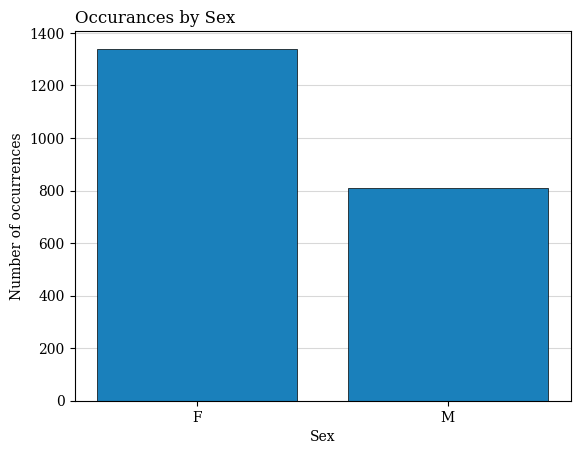

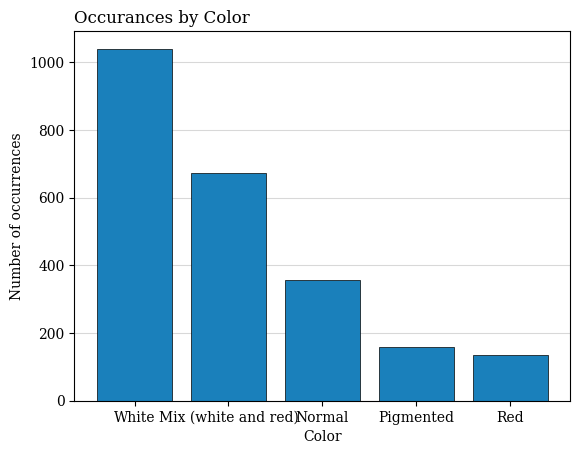

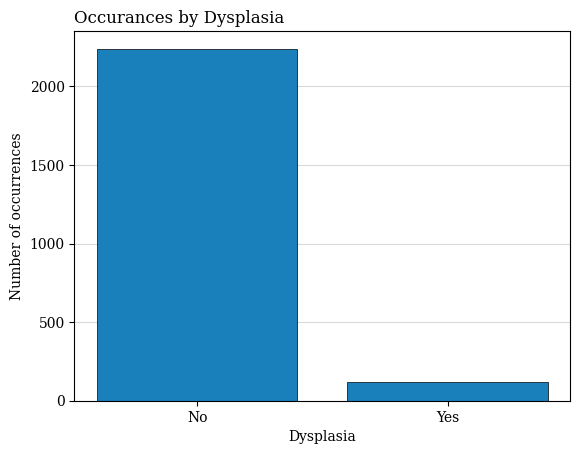

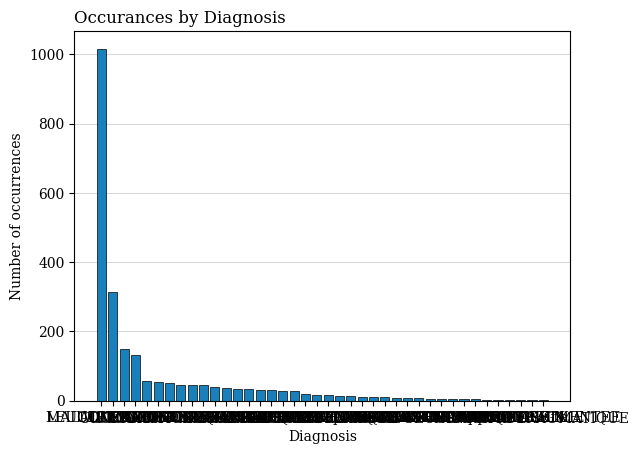

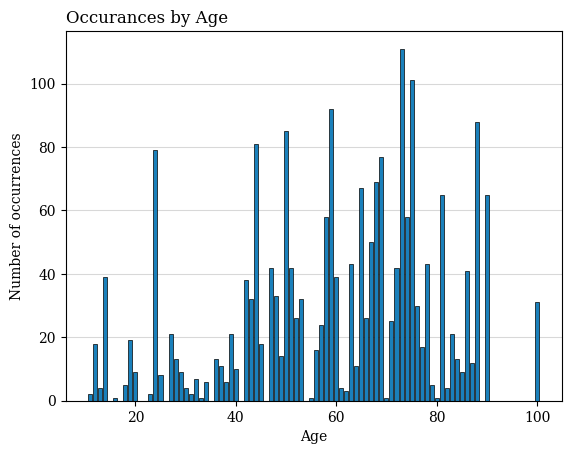

In [9]:
visualiseColumn(df,['Sex','Color','Dysplasia','Diagnosis','Age'])


In [8]:
df.isnull().sum()

Elementary lesion      0
Color                  0
Homogene               0
Well_Delimited         0
Reticulated            0
Bourgeonnant           0
Papillomatous          0
Age                  246
Sex                  213
Tobacco               41
Stupefies             40
Alcohol               15
Diagnosis             22
Dysplasia              6
dtype: int64

# **Label Encoding**

In [10]:
#Label encoding categorical datasets
df.dropna(subset=['Dysplasia'], inplace=True)

for column in df.columns:
     if df[column].dtype == 'object':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

<Axes: >

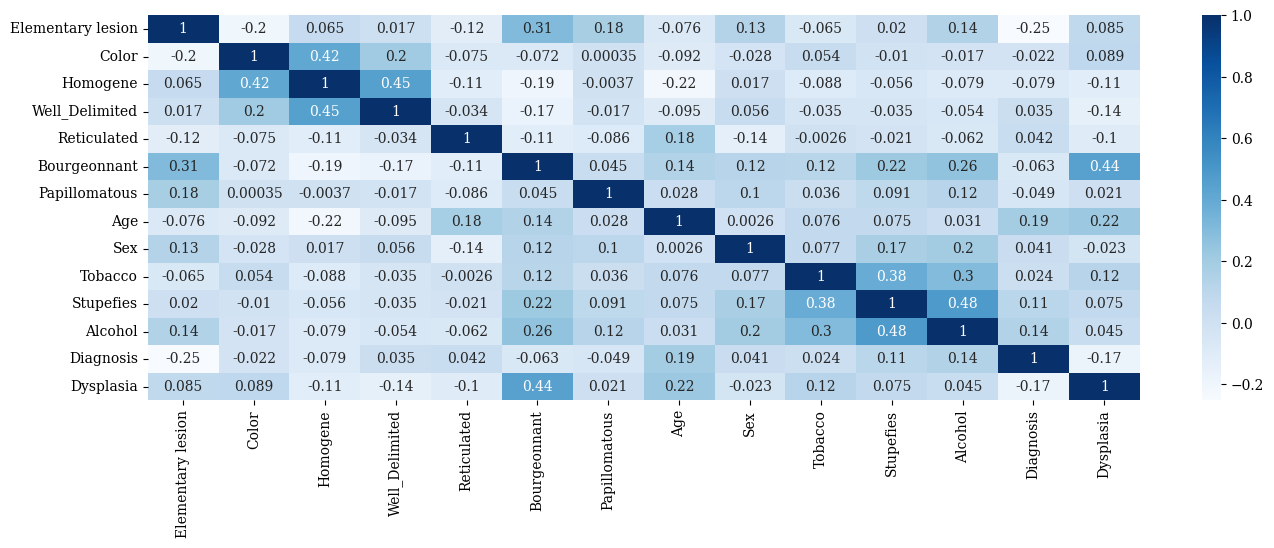

In [11]:
plotCorrelationHeatmap(df,df.columns)


In [ ]:
# sns.pairplot(df,hue='Dysplasia')

Split Dataset


In [12]:
X = df.drop(columns=['Dysplasia','Diagnosis'])
y = df[['Diagnosis','Dysplasia']]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
y_test['Dysplasia'].value_counts()

0    447
1     25
Name: Dysplasia, dtype: int64

In [14]:
# Fill NaN values
imputer = SimpleImputer(strategy='median')  # Use median to fill NaN values
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)






# **Principal Component Analysis**

Total number of components used after PCA : 12


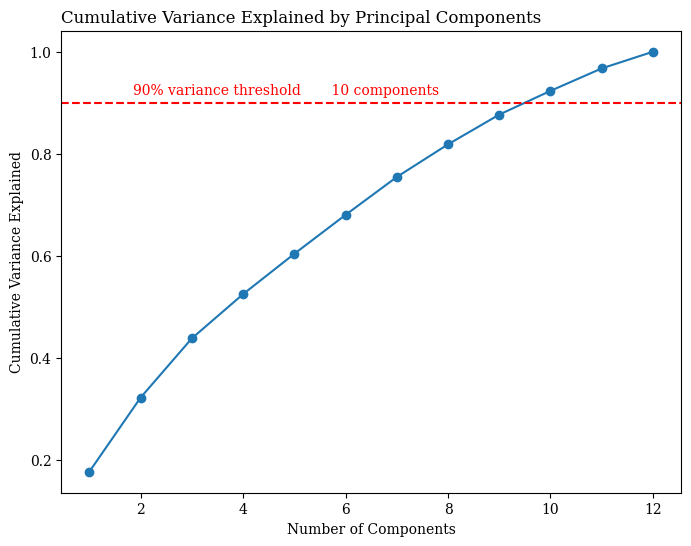

In [15]:

pca = PCA()
pca.fit(X_train_scaled)
print(f'Total number of components used after PCA : {pca.n_components_}')

# Extract the explained variances
explained_variances = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variances = np.cumsum(explained_variances)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variances) + 1), cumulative_variances, marker='o', linestyle='-')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components',loc="left")
plt.axhline(y=0.9, color='r', linestyle='--', label='90% threshold')
plt.text(8, 0.9+0.01, '90% variance threshold       10 components  ', ha='right', va='bottom', color='r')
plt.show()




# Use 0.90 treshold
pca = PCA(0.9)
pca.fit(X_train_scaled)

pca_table = pd.DataFrame({'PCA': pca.explained_variance_ratio_}, index=[f"PC{i+1}" for i in range(0, len(pca.components_))])
# display(pca_table)


X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [16]:
eigenvalues = pd.DataFrame({'Eigenvalue': pca.explained_variance_}, index=[f"C{i+1}" for i in range(0, len(pca.components_))])
eigenvalues
loadings = pca.components_
loadings_df = pd.DataFrame(loadings.T, index=[X_train.columns], columns=[f'PC{i + 1}' for i in range(len(pca.components_))])
loadings_df[['PC1', 'PC2', 'PC3', 'PC4']], eigenvalues

(                        PC1       PC2       PC3       PC4
 Elementary lesion  0.229331  0.169793 -0.574865  0.187104
 Color             -0.239164  0.390856  0.280104 -0.082537
 Homogene          -0.332262  0.505744 -0.014123  0.169670
 Well_Delimited    -0.274505  0.396369  0.035648  0.408250
 Reticulated       -0.041611 -0.334220  0.299255  0.473855
 Bourgeonnant       0.424912  0.071527 -0.201380 -0.059167
 Papillomatous      0.177945  0.160713 -0.166577  0.285805
 Age                0.191079 -0.231155  0.202814  0.613778
 Sex                0.247072  0.244758 -0.088847  0.219940
 Tobacco            0.227112  0.126958  0.480816 -0.153171
 Stupefies          0.392961  0.251971  0.359884 -0.027426
 Alcohol            0.432384  0.264427  0.148386 -0.060741,
      Eigenvalue
 C1     2.130167
 C2     1.742217
 C3     1.392589
 C4     1.040573
 C5     0.948271
 C6     0.915446
 C7     0.890959
 C8     0.768300
 C9     0.698799
 C10    0.558913)

In [17]:
# Two dataset to train the model
all_dataset = [(X_train_pca,X_test_pca),(X_train_scaled,X_test_scaled)]

In [18]:
# # Train SVM model
y_train_dysplasia = y_train.drop(columns = ['Diagnosis'])
y_test_dysplasia = y_test.drop(columns=['Diagnosis'])

# for x_train,x_test in all_dataset:
#   use_SVM(x_train,x_test,y_train_dysplasia,y_test_dysplasia)

Algorithm  SVM
Best score: 0.9739926068062532
Best Params {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Algorithm  DecisionTree
Best score: 0.9819572210621367
Best Params {'max_depth': 20, 'min_samples_split': 2}

Algorithm  RandomForest
Best score: 0.9862040747220497
Best Params {'max_depth': None}

Algorithm  KNN
Best score: 0.9835515548281506
Best Params {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}



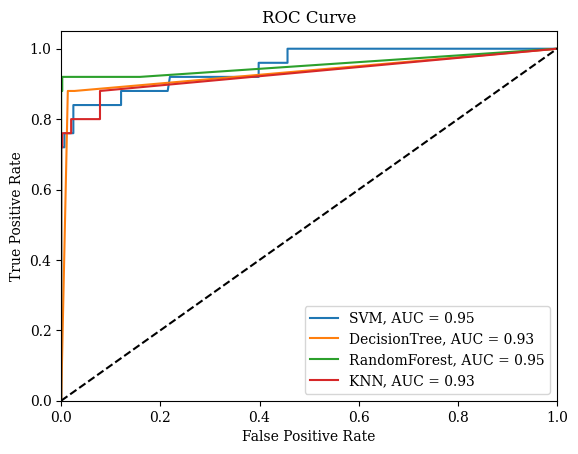

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc



# Define models and parameters
models = {
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

params = {
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 'auto']},
    'DecisionTree': {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'RandomForest': {'max_depth': [None, 10, 20]},
    'KNN': {'n_neighbors': range(1,10), 'p': [1, 2], 'weights': ['uniform', 'distance']}
}


# Grid search for each model
best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, params[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train_dysplasia.to_numpy().ravel())
    best_model = grid_search.best_estimator_

    y_score = best_model.predict_proba(X_test_scaled)[:, 1]

    best_models[name] = best_model
    fpr, tpr, _ = roc_curve(y_test_dysplasia, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{name}, AUC = {roc_auc:.2f}')

    print("Algorithm ",name)
    print("Best score:",grid_search.best_score_)
    print("Best Params",grid_search.best_params_)
    print("")


plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


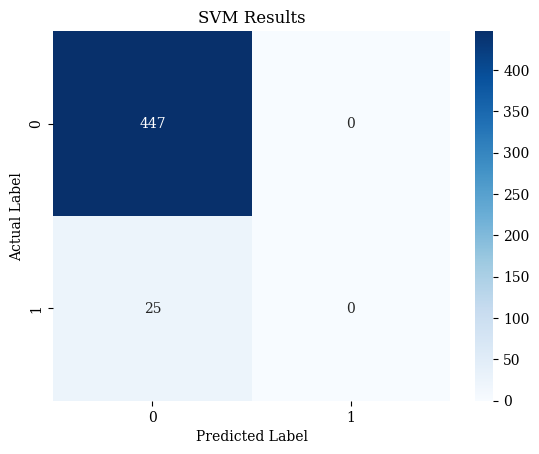

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


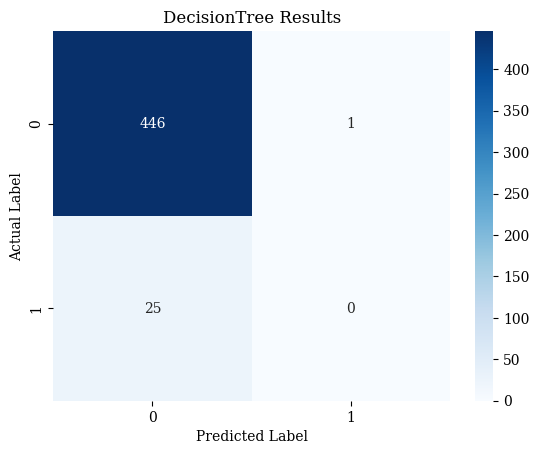

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


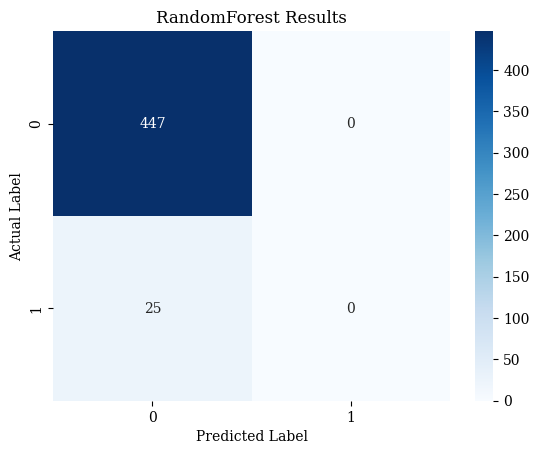

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


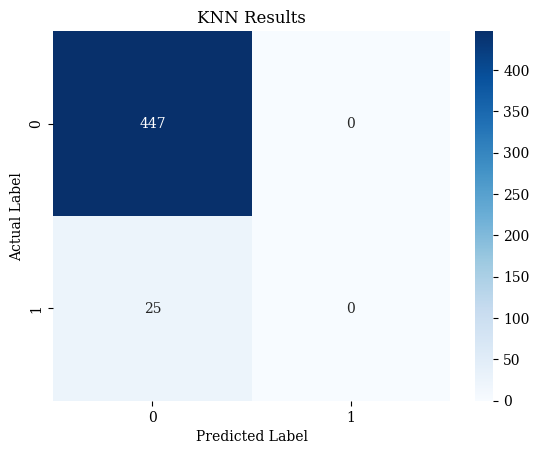

In [22]:
# Evaluate models
evaluation_metrics = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    evaluation_metrics[name] = {
        'Accuracy': accuracy_score(y_test_dysplasia, y_pred),
        'Precision': precision_score(y_test_dysplasia, y_pred, average='macro'),
        'Recall': recall_score(y_test_dysplasia, y_pred, average='macro'),
        'F1-Score': f1_score(y_test_dysplasia, y_pred, average='macro')
    }
    # Confusion matrix
    cm = confusion_matrix(y_test_dysplasia, y_pred)
    sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(f'{name} Results')
    plt.show()

[94.70338983050848, 94.49152542372882, 94.70338983050848, 94.70338983050848]


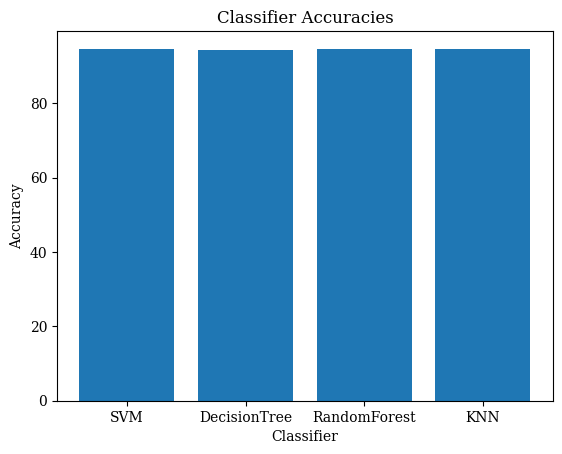

In [23]:
# Extract accuracy values

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracies = [evaluation_metrics[classifier]['Accuracy']*100 for classifier in evaluation_metrics]
print(accuracies)
# Plot histogram
classifiers =list(evaluation_metrics.keys())
plt.bar(classifiers, accuracies)
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.title('Classifier Accuracies')
plt.show()

<Axes: ylabel='Dysplasia'>

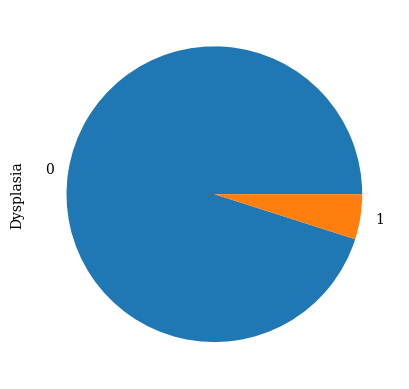

In [ ]:
df['Dysplasia'].value_counts().plot.pie()

# **ML**

**SVM**

In [26]:
# %pip install shap
import shap
svm = SVC(kernel='rbf', probability=True, C=10, gamma='scale')
svm.fit(X_train, y_train_dysplasia)

shap.initjs()
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)

# plot the SHAP values for the Setosa output of the first instance
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 5.0 MB/s eta 0:00:00


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


  0%|          | 0/472 [00:00<?, ?it/s]

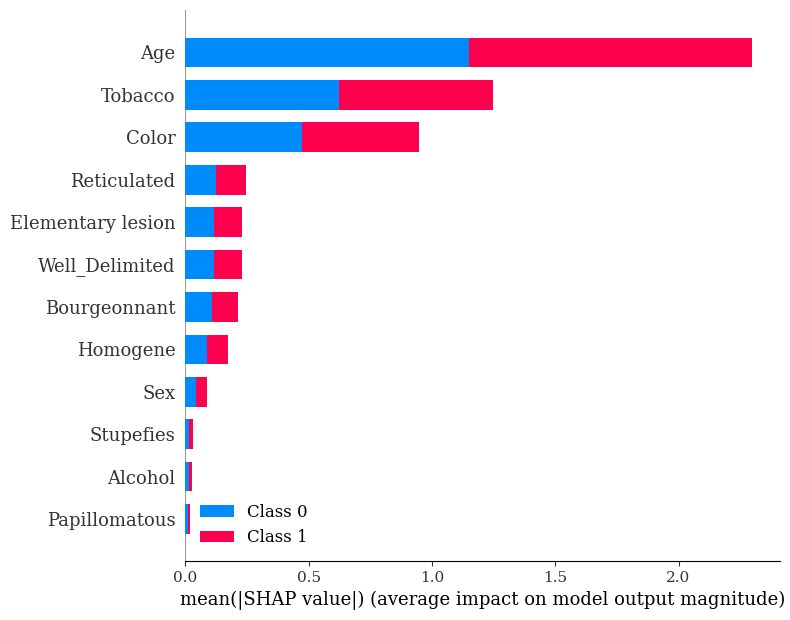

In [39]:
shap.summary_plot(shap_values, X_test)
# Class 0 = No

In [73]:
dataset = read_csv(lesions,sep=";")
dataset['Color'].unique(), df['Color'].unique()

(array(['White', 'Mix (white and red)', 'Normal', 'Pigmented', 'Red'],
       dtype=object),
 array([4, 0, 1, 2, 3]))

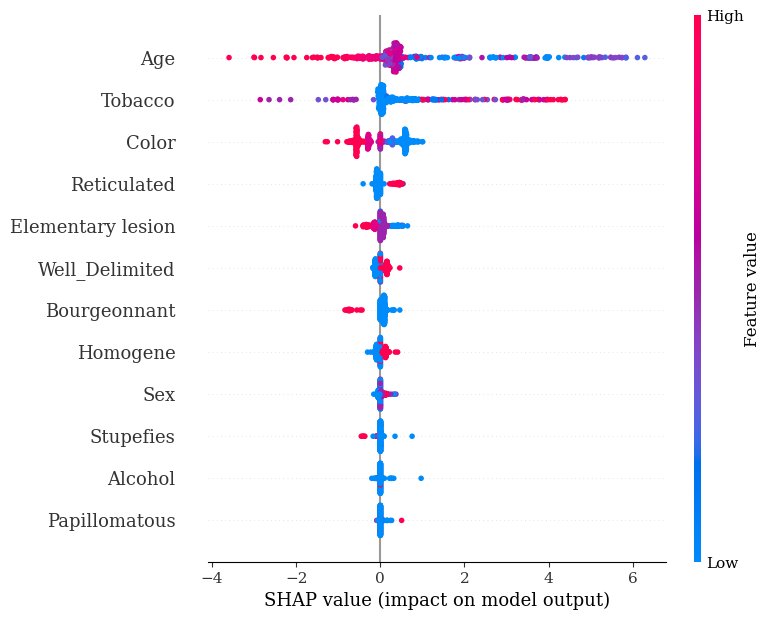

In [55]:
# Model summary for 'no'
shap.summary_plot(shap_values[0], X_test)

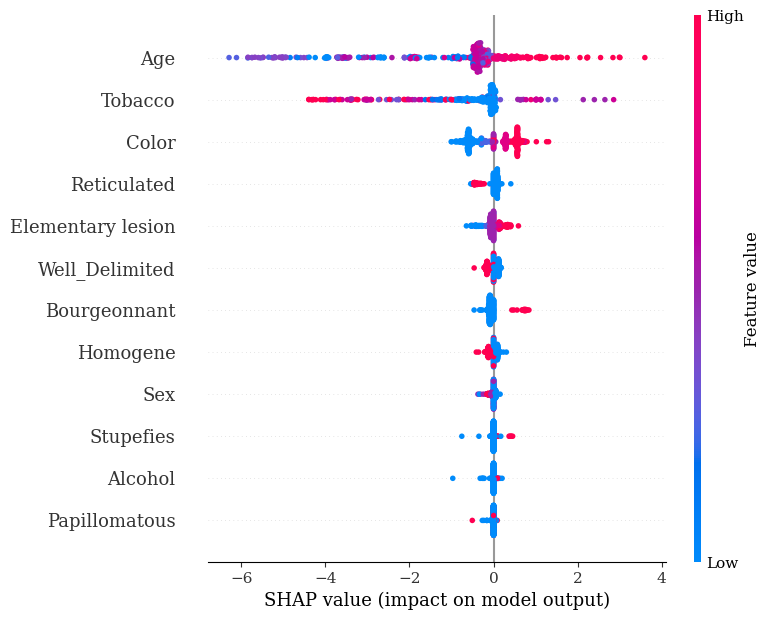

In [56]:
# model summary for 'yes'
shap.summary_plot(shap_values[1], X_test)

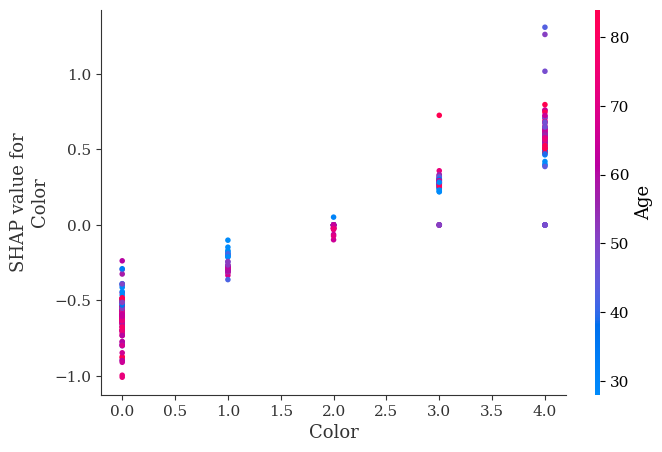

(array(['White', 'Mix (white and red)', 'Normal', 'Pigmented', 'Red'],
       dtype=object),
 array([4, 0, 1, 2, 3]))

In [75]:
shap.dependence_plot("Color", shap_values[1], X_test.iloc[0:1000,:])
dataset["Color"].unique(), df['Color'].unique()

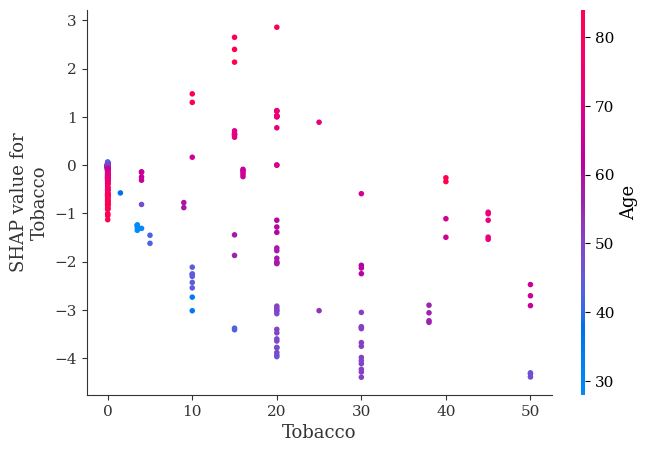

In [78]:
shap.dependence_plot("Tobacco", shap_values[1], X_test.iloc[0:1000,:])

**kNN**

In [83]:
knn = KNeighborsClassifier(n_neighbors=5, p=1, weights='distance')
knn.fit(X_train, y_train_dysplasia)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


KNeighborsClassifier(p=1, weights='distance')

In [93]:
knn_explainer = shap.KernelExplainer(knn.predict_proba, X_train)
knn_shap_values = knn_explainer.shap_values(X_test, nsamples=100)

  0%|          | 0/472 [00:00<?, ?it/s]

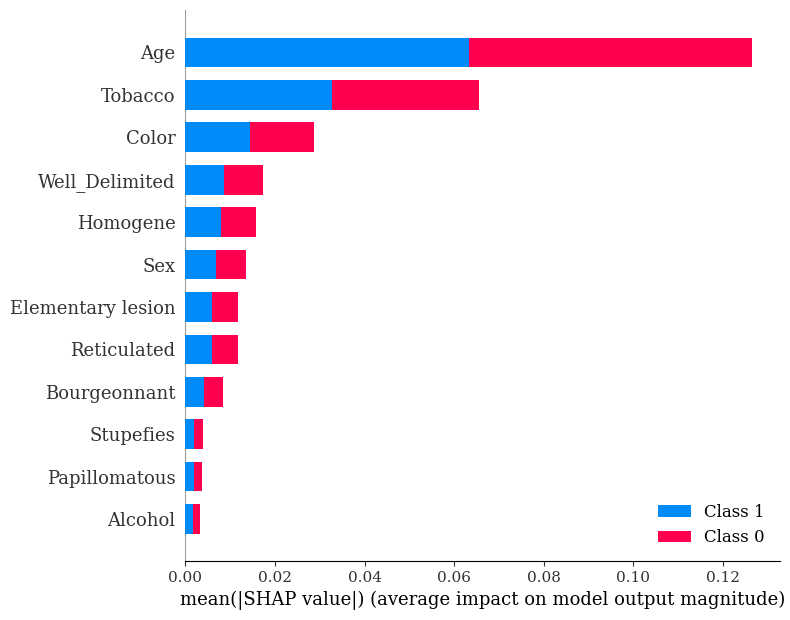

In [96]:
shap.summary_plot(knn_shap_values, X_test)

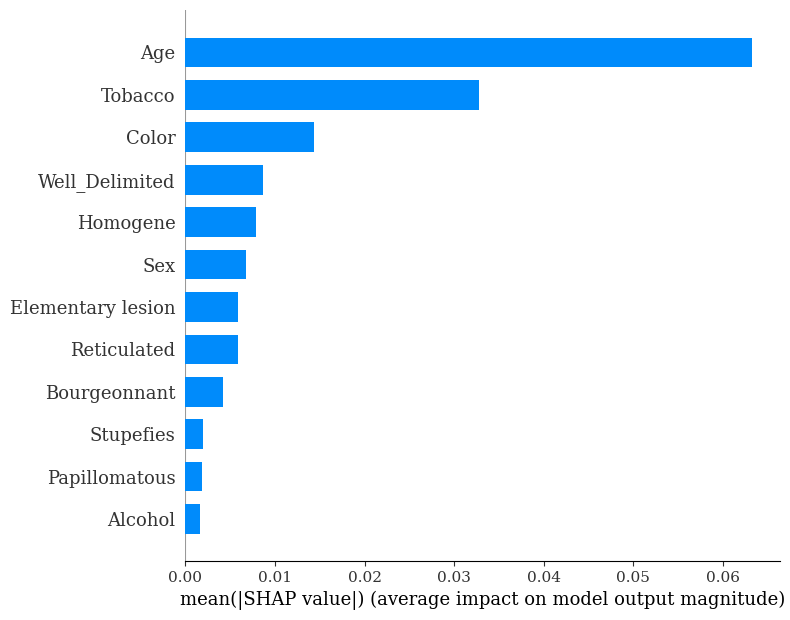

In [109]:
shap.summary_plot(knn_shap_values[1], X_test, plot_type="bar")

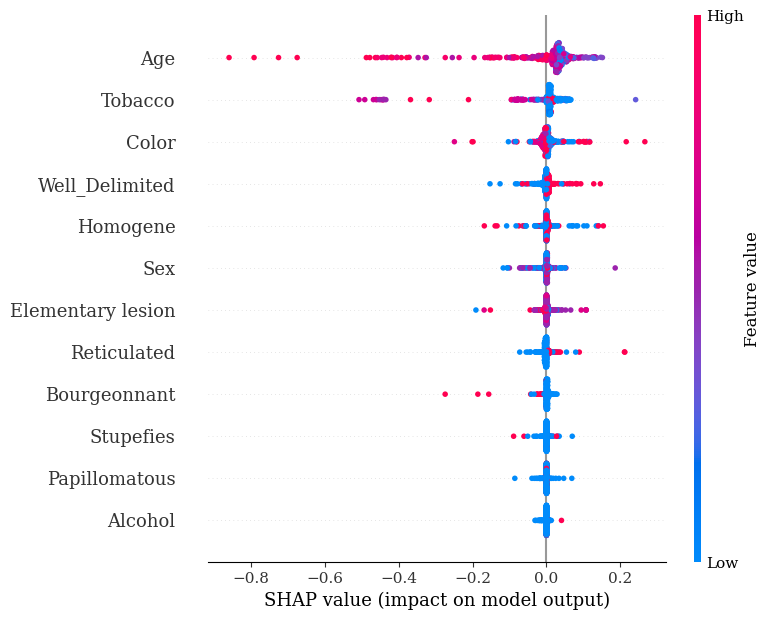

In [94]:
shap.summary_plot(knn_shap_values[0], X_test)

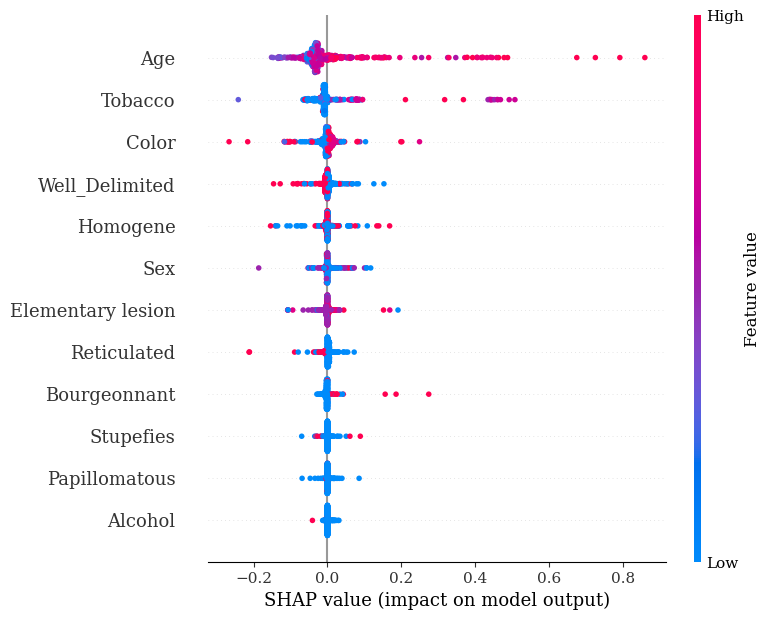

In [95]:
shap.summary_plot(knn_shap_values[1], X_test)

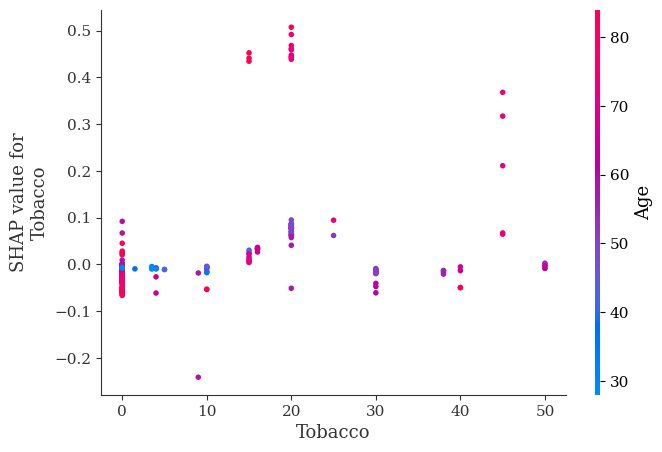

In [97]:
shap.dependence_plot("Tobacco", knn_shap_values[1], X_test)

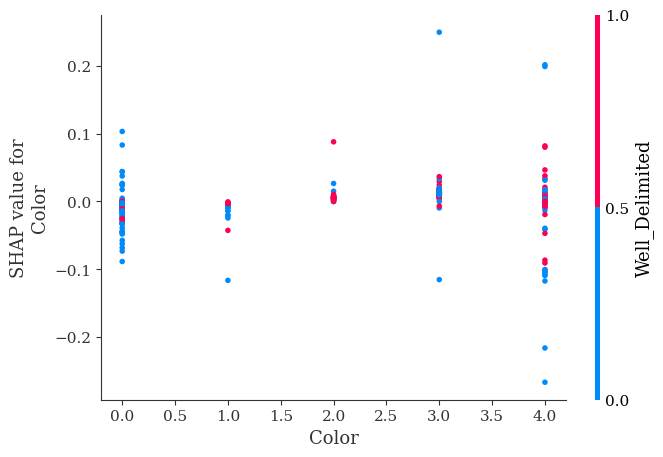

In [98]:
shap.dependence_plot("Color", knn_shap_values[1], X_test)

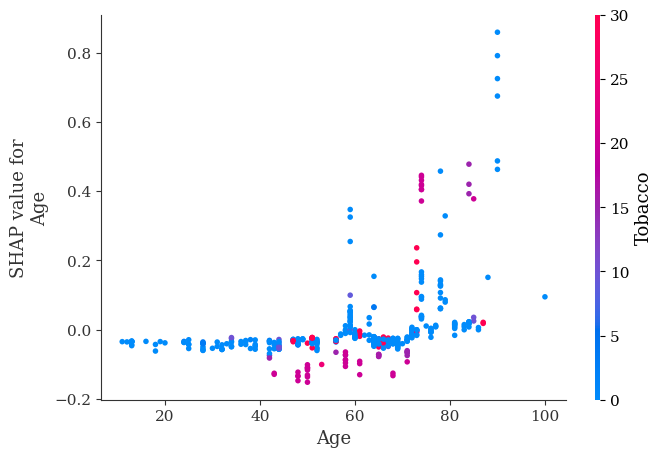

In [99]:
shap.dependence_plot("Age", knn_shap_values[1], X_test)

**Random Forest Classifier**

In [100]:
rfc = RandomForestClassifier(max_depth = None)
rfc.fit(X_train, y_train_dysplasia)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier()

In [102]:
rfc_explainer = shap.KernelExplainer(rfc.predict_proba, X_train)
rfc_shap_values = rfc_explainer.shap_values(X_test, nsamples=100)

  0%|          | 0/472 [00:00<?, ?it/s]

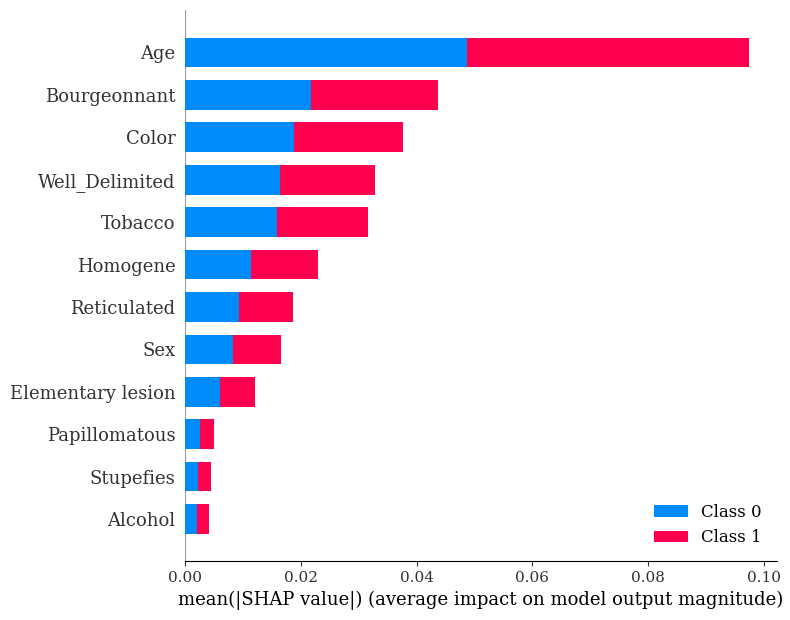

In [103]:
shap.summary_plot(rfc_shap_values, X_test)

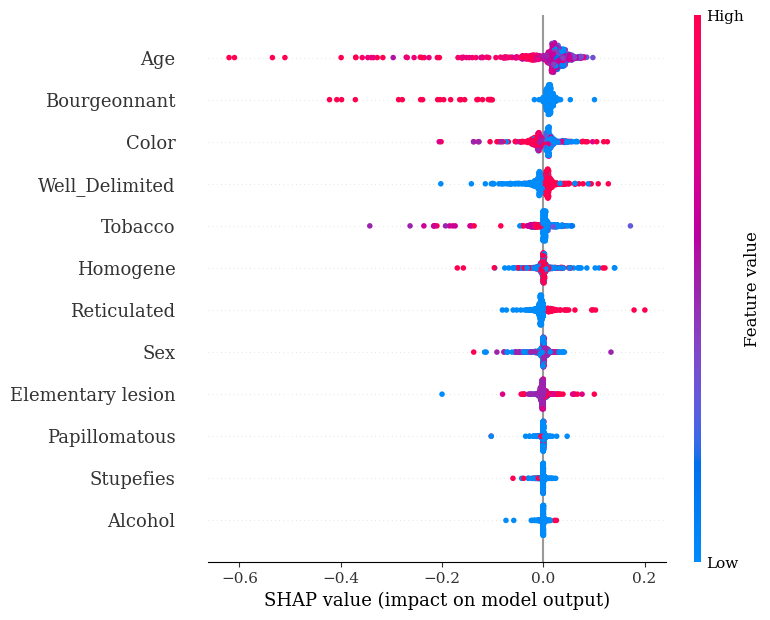

In [104]:
shap.summary_plot(rfc_shap_values[0], X_test)

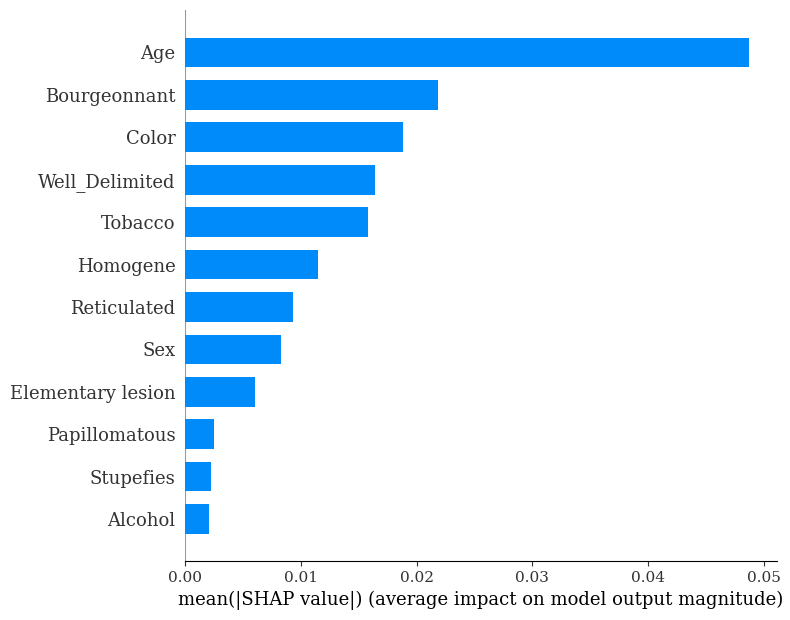

In [110]:
shap.summary_plot(rfc_shap_values[0], X_test, plot_type='bar')

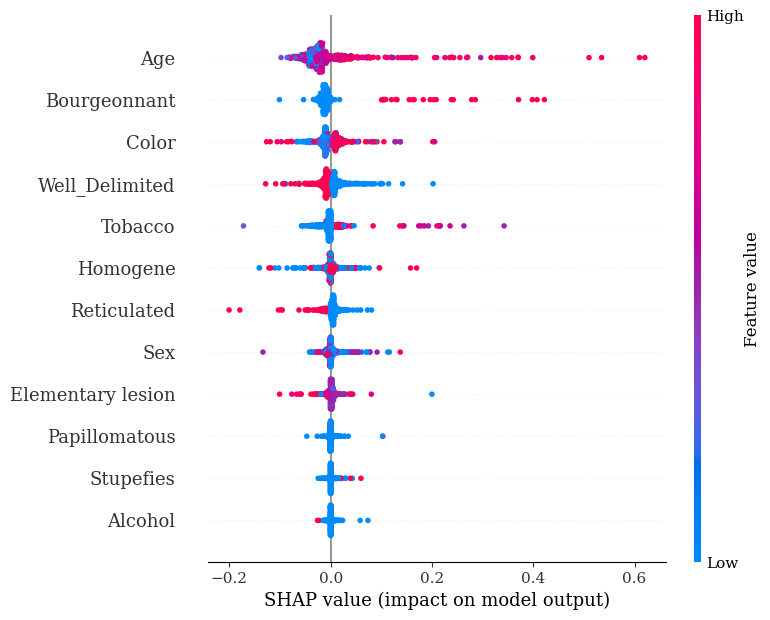

In [105]:
shap.summary_plot(rfc_shap_values[1], X_test)

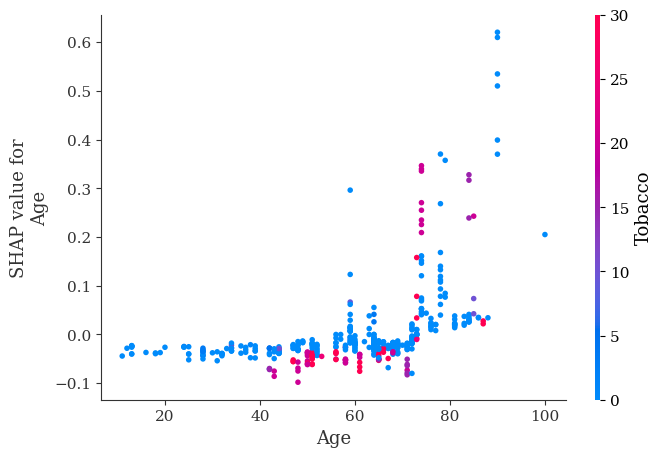

In [106]:
shap.dependence_plot("Age", rfc_shap_values[1], X_test)

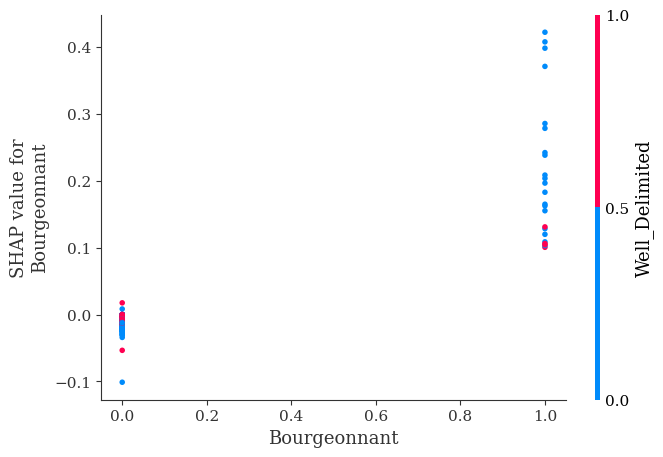

In [119]:
shap.dependence_plot("Bourgeonnant", rfc_shap_values[1], X_test)

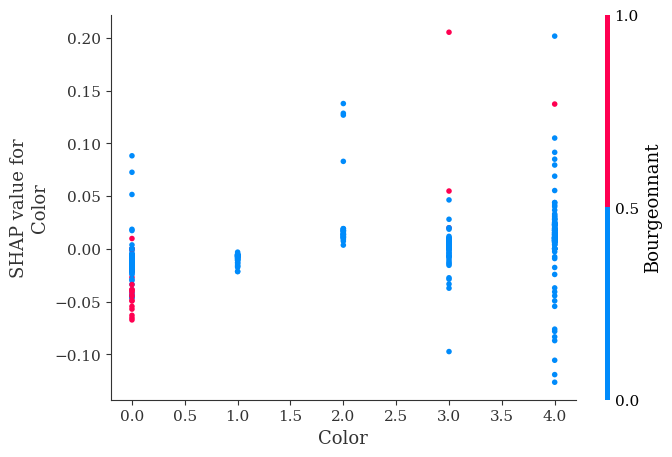

In [118]:
shap.dependence_plot("Color", rfc_shap_values[1], X_test)